In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries**

In [2]:
# Install nibabel, a package required for NIfTI image manipulation, if it's not already available in the environment.
!pip install nibabel
import os
import numpy as np
import keras
import sys
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as Metrics
from tensorflow.keras.metrics import TruePositives, FalseNegatives
from keras import losses
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data_dir = '/content/drive/My Drive/nii_images/'
label_dir = '/content/drive/My Drive/nii_segmentations/'

**Progress Bar**

In [5]:
def progress_bar(progress, total):
    percentage = (progress / total) * 100
    bar = ('█' * int(percentage)) + ('-' * (100 - int(percentage)))
    print(f"\r|{bar}| {percentage:.2f}%")
    return

**loss Functions**

In [6]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_metric(y_true, y_pred)


def weighted_bincrossentropy(true, pred, weight_zero = 0.625, weight_one = 1):
        # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)

    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return keras.backend.mean(weighted_bin_crossentropy)

**Evaluation Metrics**

In [7]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def true_positive_rate(y_true, y_pred):
    """
    Calculate the True Positive Rate (Sensitivity/Recall).
    Args:
    - y_true: The ground truth labels.
    - y_pred: The predicted labels.

    Returns:
    - The True Positive Rate (TPR).
    """
    # Convert y_pred to binary (0 or 1) based on a 0.5 threshold.
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate True Positives and False Negatives
    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_binary, 1)), tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_binary, 0)), tf.float32))

    # Calculate True Positive Rate
    tpr = tp / (tp + fn + tf.keras.backend.epsilon()) # Added epsilon to avoid division by zero
    return tpr

**Data Handling Functions**

In [8]:
def load_nii_image(filepath, crop_x, crop_y):
    """Load a NIfTI image and normalize it."""
    img = nib.load(filepath).get_fdata()
    min_val = np.min(img)
    max_val = np.max(img)
    normalized = ((img - min_val) / (max_val - min_val))
    normalized = normalized[crop_y:crop_y+256, crop_x:crop_x+256, :]  # Crop the image
    return normalized

def load_nii_Hu_image(filepath, crop_x, crop_y):
    """Load a NIfTI image, apply Hounsfield unit windowing, and normalize."""
    img = nib.load(filepath).get_fdata()
    window_center = 60
    window_width = 12
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)
    img_windowed = np.clip(img, lower_bound, upper_bound)
    img_normalized = (img_windowed - lower_bound) / (upper_bound - lower_bound)
    normalized = img_normalized[crop_y:crop_y+256, crop_x:crop_x+256, :]  # Crop the image
    return normalized

def augment_image(image, mask):
    """
    Perform random horizontal flips and rotations on the image and mask.
    """
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotation
    rotation = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=rotation)
    mask = tf.image.rot90(mask, k=rotation)

    return image, mask


**Hyper Parameters**

In [ ]:
params = {
    'loss_function': weighted_bincrossentropy,
    'batch_size': 32,
    'epochs': 40,
    'zero_value_pixel': 0.0,
    'threshold': 0.275,
    'learning_rate': 0.001,
    'images_count': 51,
    'crop_x': 150,
    'crop_y': 50,
}


**Unet Model**

In [9]:
def unet_model(input_size):
    inputs = Input(input_size)

    # Downward path
    c0 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p0 = MaxPooling2D((2, 2))(c0)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(p0)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)

    # Upward path
    u2 = UpSampling2D((2, 2))(c5)
    merge2 = concatenate([u2, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge2)

    # Upward path
    u3 = UpSampling2D((2, 2))(c6)
    merge3 = concatenate([u3, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge3)

    u4 = UpSampling2D((2, 2))(c7)
    merge4 = concatenate([u4, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge4)

    u5 = UpSampling2D((2, 2))(c8)
    merge5 = concatenate([u5, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge5)

    u6 = UpSampling2D((2, 2))(c9)
    merge6 = concatenate([u6, c0])
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def load_and_preprocess_images(data_dir, label_dir, params):
    images = []
    masks = []
    bad_images =[32,34,38,41,47,50]
    for i in range(params['images_count']):
        # Skip the bad images based on their index
        if i in bad_images:
            print(f"Skipping bad image at index: {i}")
            continue
        progress_bar(i + 1, params['images_count'])
        img = load_nii_Hu_image(os.path.join(data_dir, f"volume-{i}.nii"), params['crop_x'], params['crop_y'])
        mask = load_nii_image(os.path.join(label_dir, f"segmentation-{i}.nii"), params['crop_x'], params['crop_y'])
        for j in range(mask.shape[2]):  # Iterate through slices
            if np.sum(mask[:,:,j] > params['zero_value_pixel']) / (mask.shape[0] * mask.shape[1]) > params['threshold']:
                slice_img = img[:,:,j]
                slice_mask = mask[:,:,j]

                # Convert slices to the right format
                slice_img_tf = tf.expand_dims(tf.convert_to_tensor(slice_img, dtype=tf.float32), axis=-1)
                slice_mask_tf = tf.expand_dims(tf.convert_to_tensor(slice_mask, dtype=tf.float32), axis=-1)

                # Append original images first
                images.append(slice_img)
                masks.append(slice_mask)

                # Apply augmentation
                aug_img, aug_mask = augment_image(slice_img_tf, slice_mask_tf)

                # Convert tensors back to numpy arrays and append
                images.append(aug_img.numpy().squeeze())
                masks.append(aug_mask.numpy().squeeze())

    images = np.array(images)[..., np.newaxis]  # Add a channel dimension
    masks = np.array(masks)[..., np.newaxis]
    print("Loading and preprocessing complete. Total images:", len(images))
    return images, masks


**Load the images and masks**

In [11]:
images, masks = load_and_preprocess_images(data_dir, label_dir, params)

|█---------------------------------------------------------------------------------------------------| 1.96%
|███-------------------------------------------------------------------------------------------------| 3.92%
|█████-----------------------------------------------------------------------------------------------| 5.88%
|███████---------------------------------------------------------------------------------------------| 7.84%
|█████████-------------------------------------------------------------------------------------------| 9.80%
|███████████-----------------------------------------------------------------------------------------| 11.76%
|█████████████---------------------------------------------------------------------------------------| 13.73%
|███████████████-------------------------------------------------------------------------------------| 15.69%
|█████████████████-----------------------------------------------------------------------------------| 17.65%
|██████████████

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Initialize and compile the model
model = unet_model((256, 256, 1))
model.summary()

# Compile the model using Adam optimizer with the learning rate from params
optimizer = Adam(learning_rate=params['learning_rate'])
model.compile(optimizer=optimizer, loss=params['loss_function'], metrics=["accuracy",dice_metric,true_positive_rate])

# Set up the model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath="model_weights_{epoch:02d}.h5", save_weights_only=True)

# Train the model using the training data
#model.fit(images, masks, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, callbacks=[model_checkpoint])
model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, callbacks=[model_checkpoint])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         18496     ['max_pooling2d[0][0]']   

**Plot Results**

In [13]:
from matplotlib.colors import NoNorm
def plot_results(original, truth, prediction):
    original = original[..., 0]
    truth = truth[..., 0]
    prediction = prediction[..., 0]

    difference = np.abs(truth - prediction)

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))

    ax[0].imshow(original, cmap='gray', norm=NoNorm())
    ax[0].set_title("Original Image")

    ax[1].imshow(truth, cmap='gray', norm=NoNorm())
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(prediction, cmap='gray', norm=NoNorm())
    ax[2].set_title("Predicted Mask")

    #ax[3].imshow(difference, cmap='gray', norm=NoNorm())
    #ax[3].set_title("Difference")

    for a in ax:
        a.axis('off')

    plt.show()

**Main**

35/35 [==============================] - 2s 39ms/step
Plotting selected results from the original dataset...


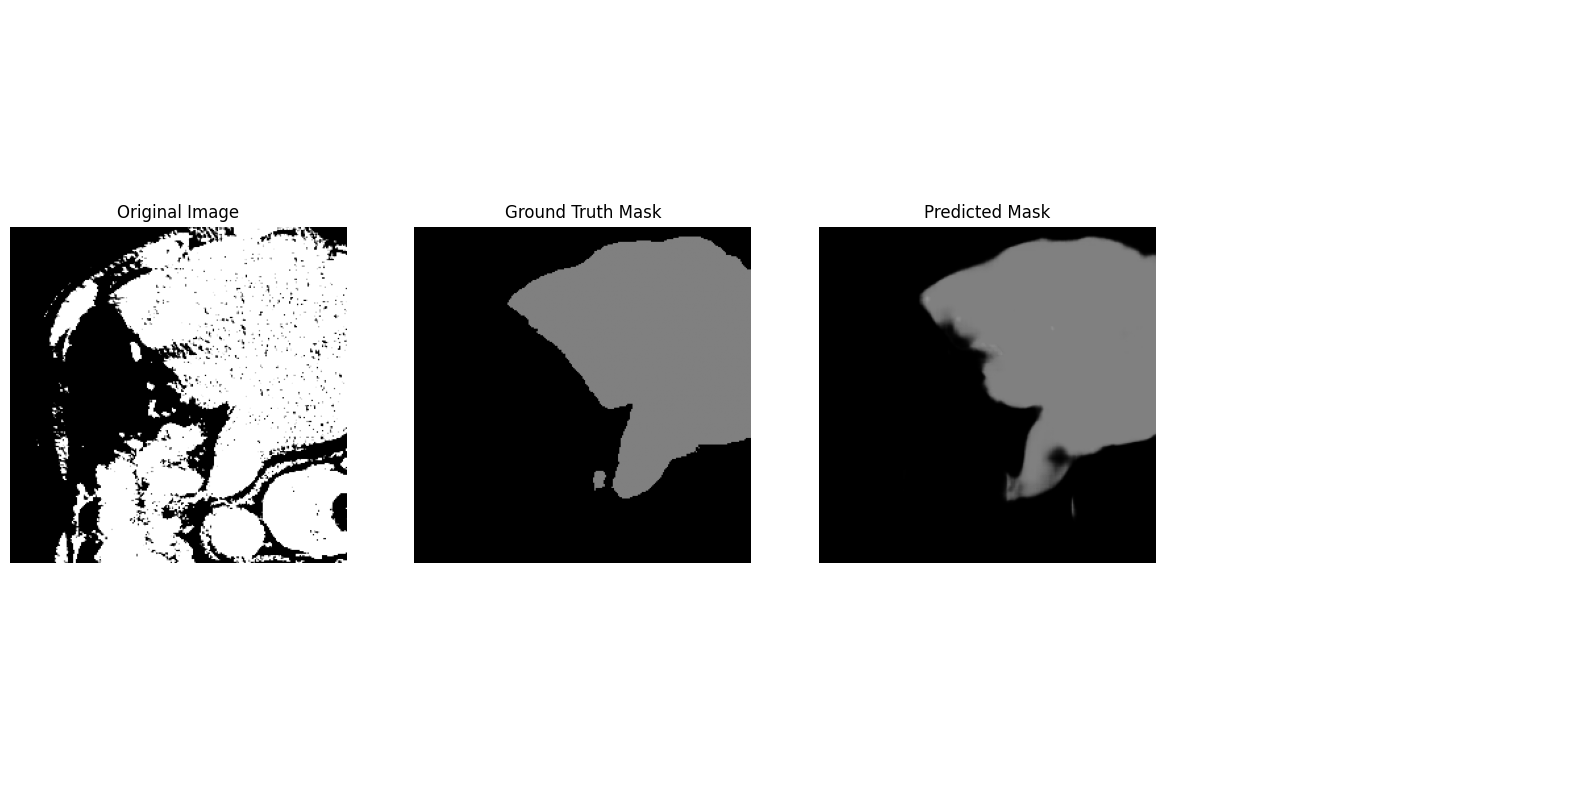

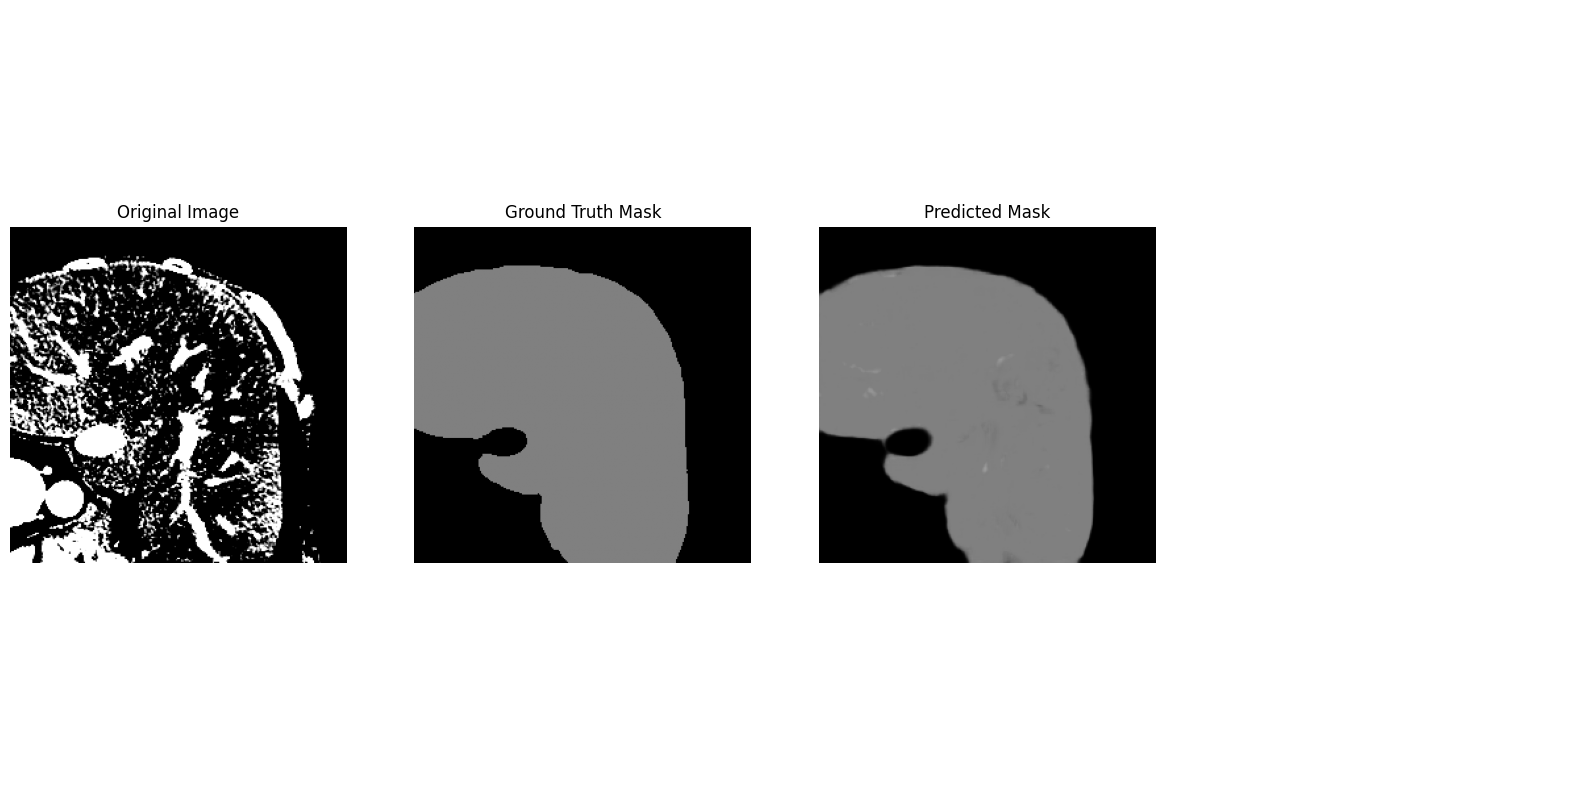

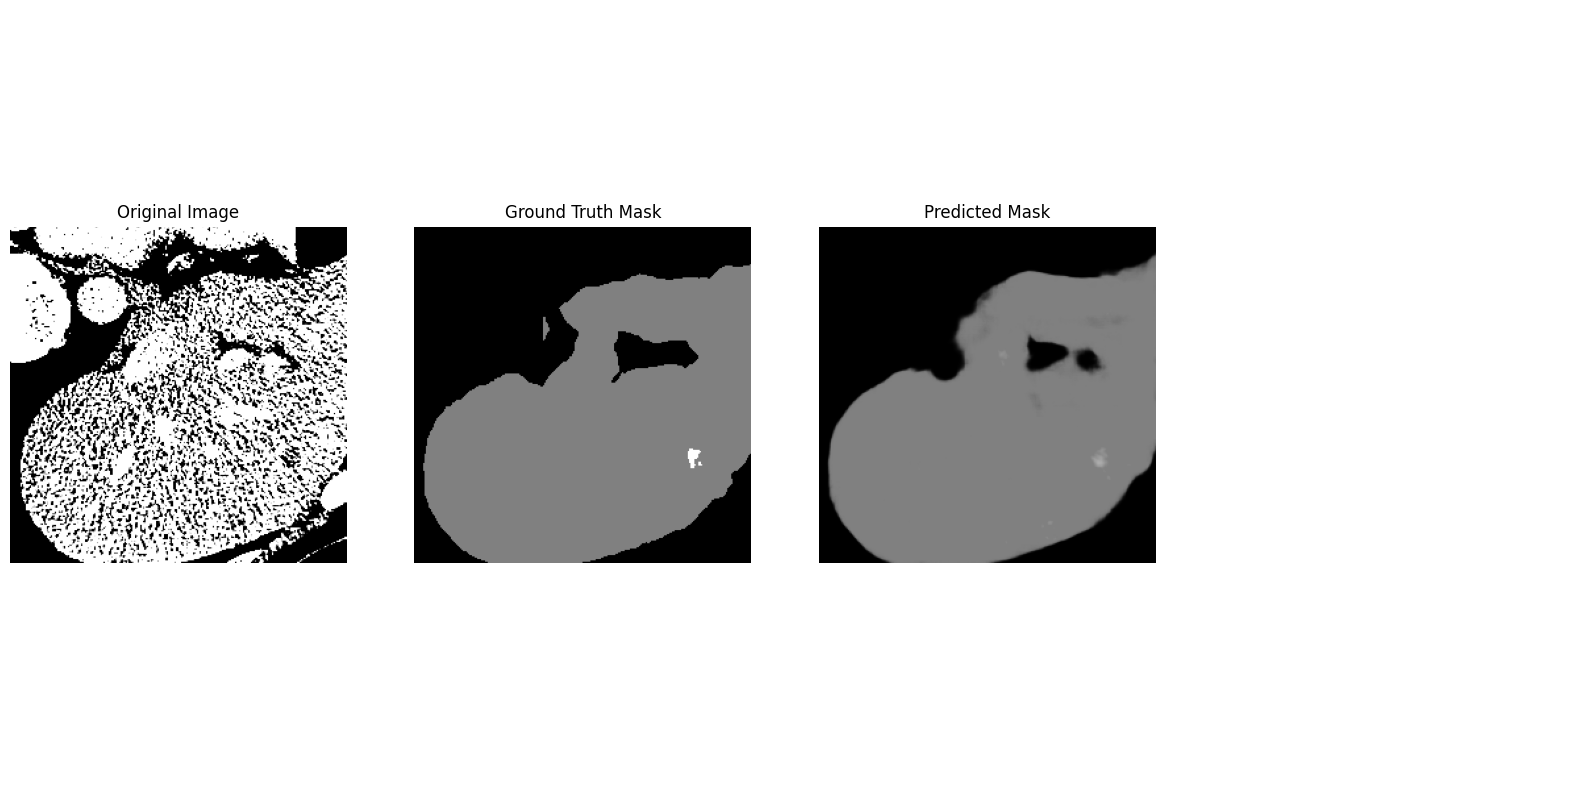

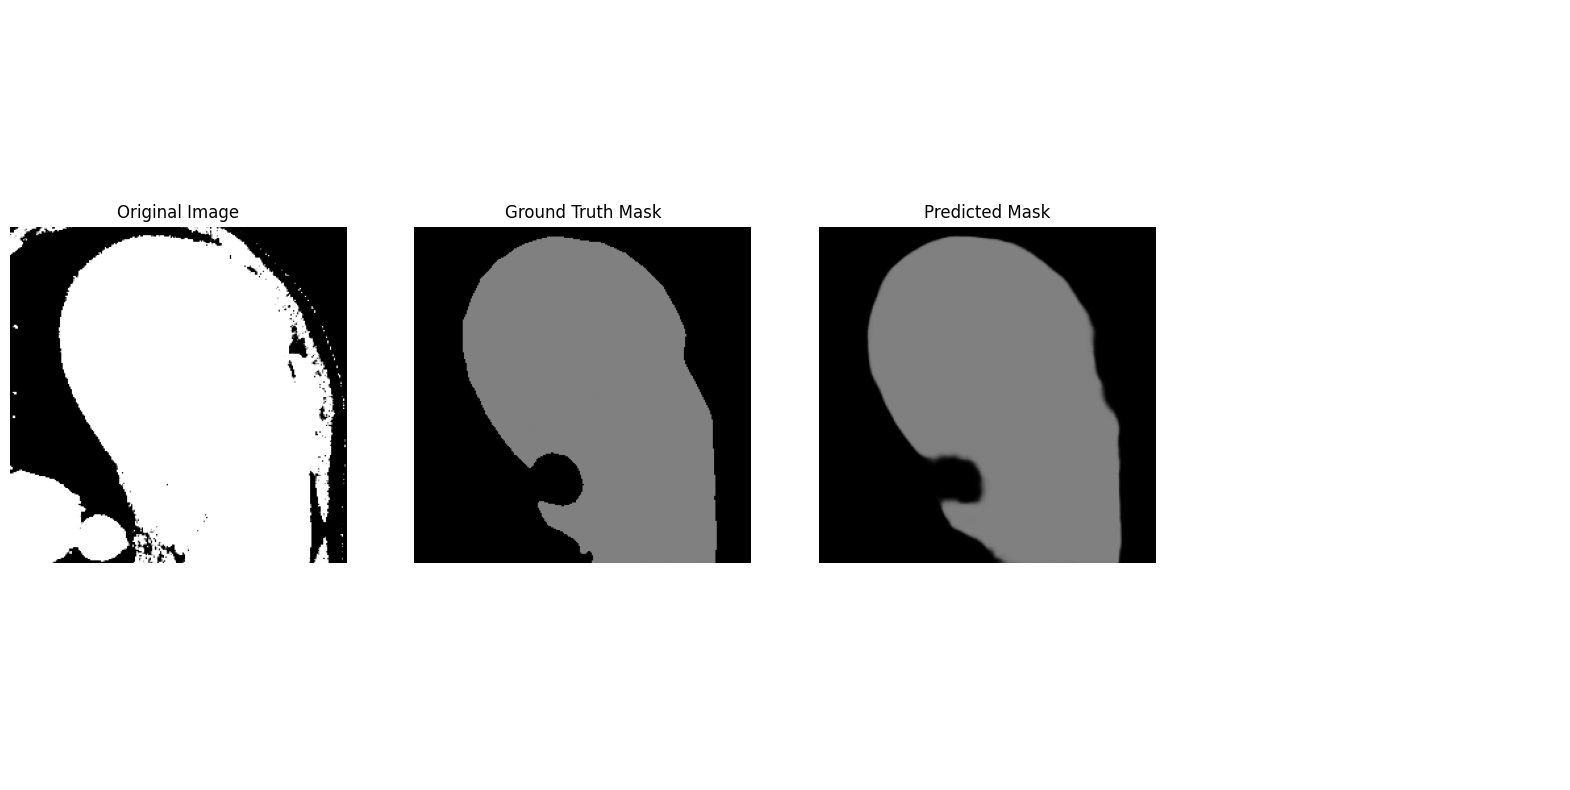

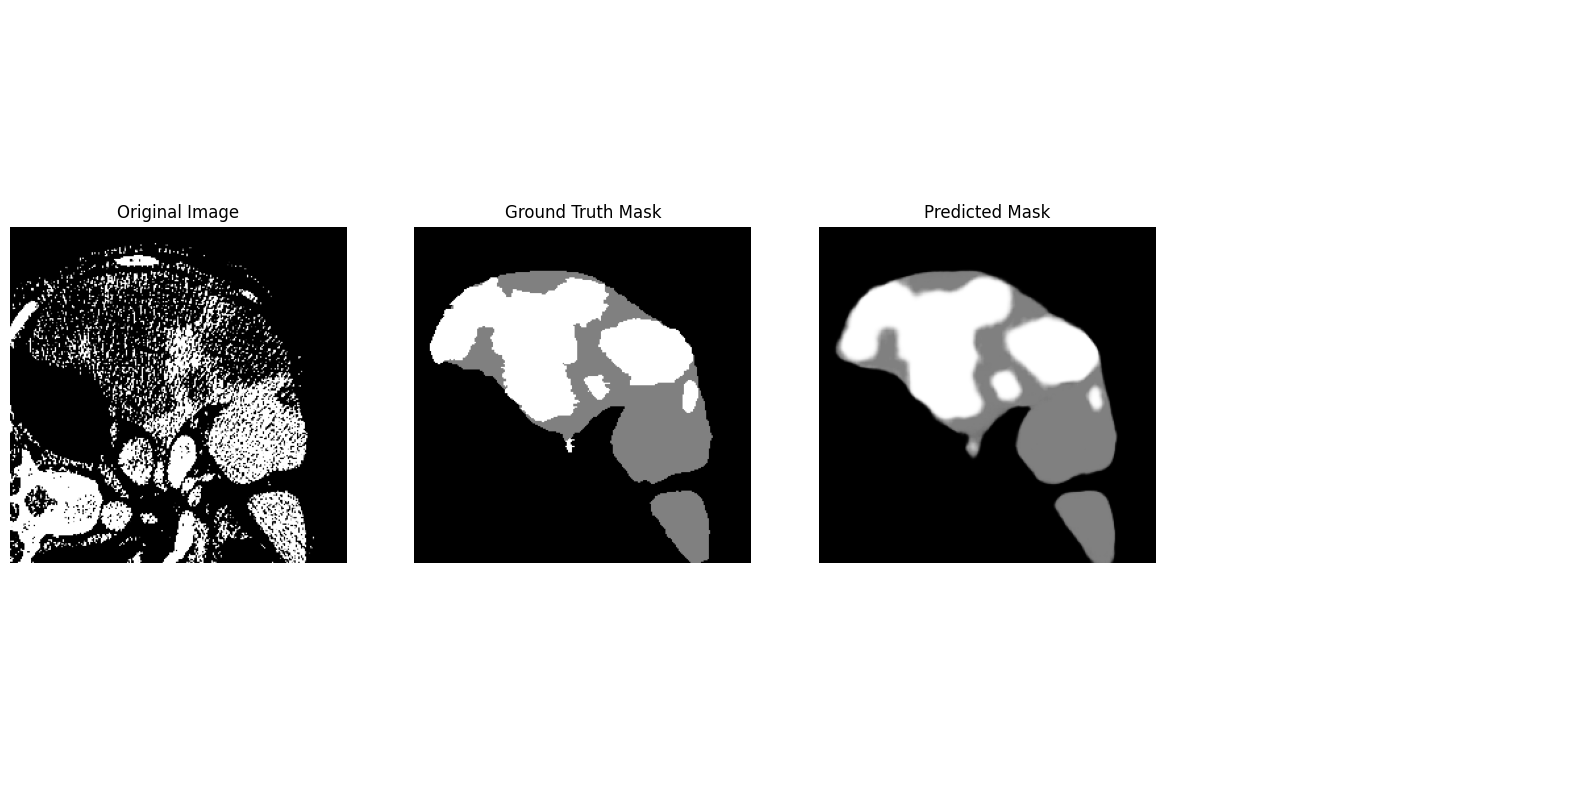

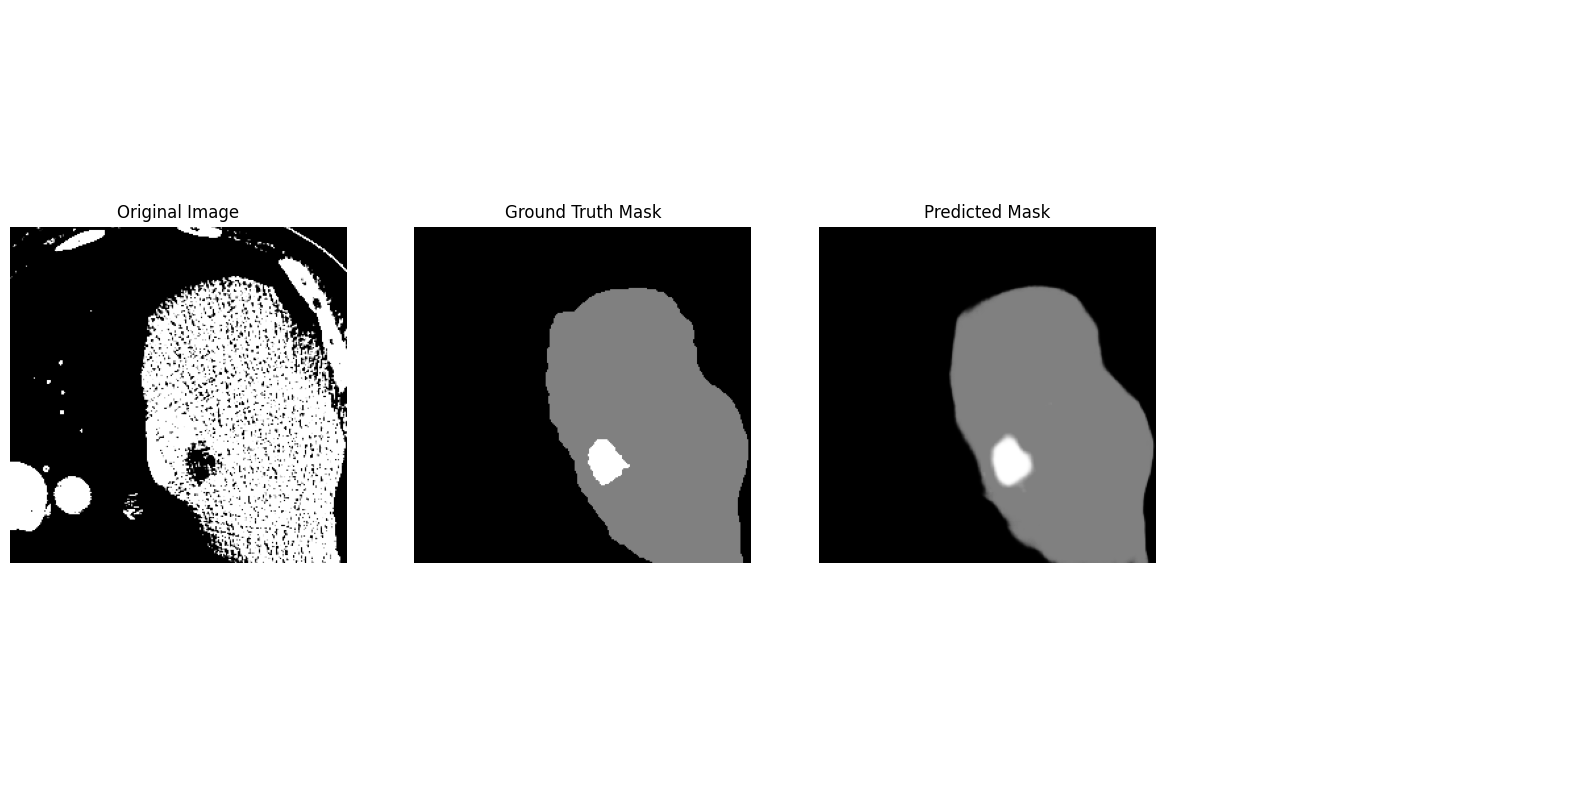

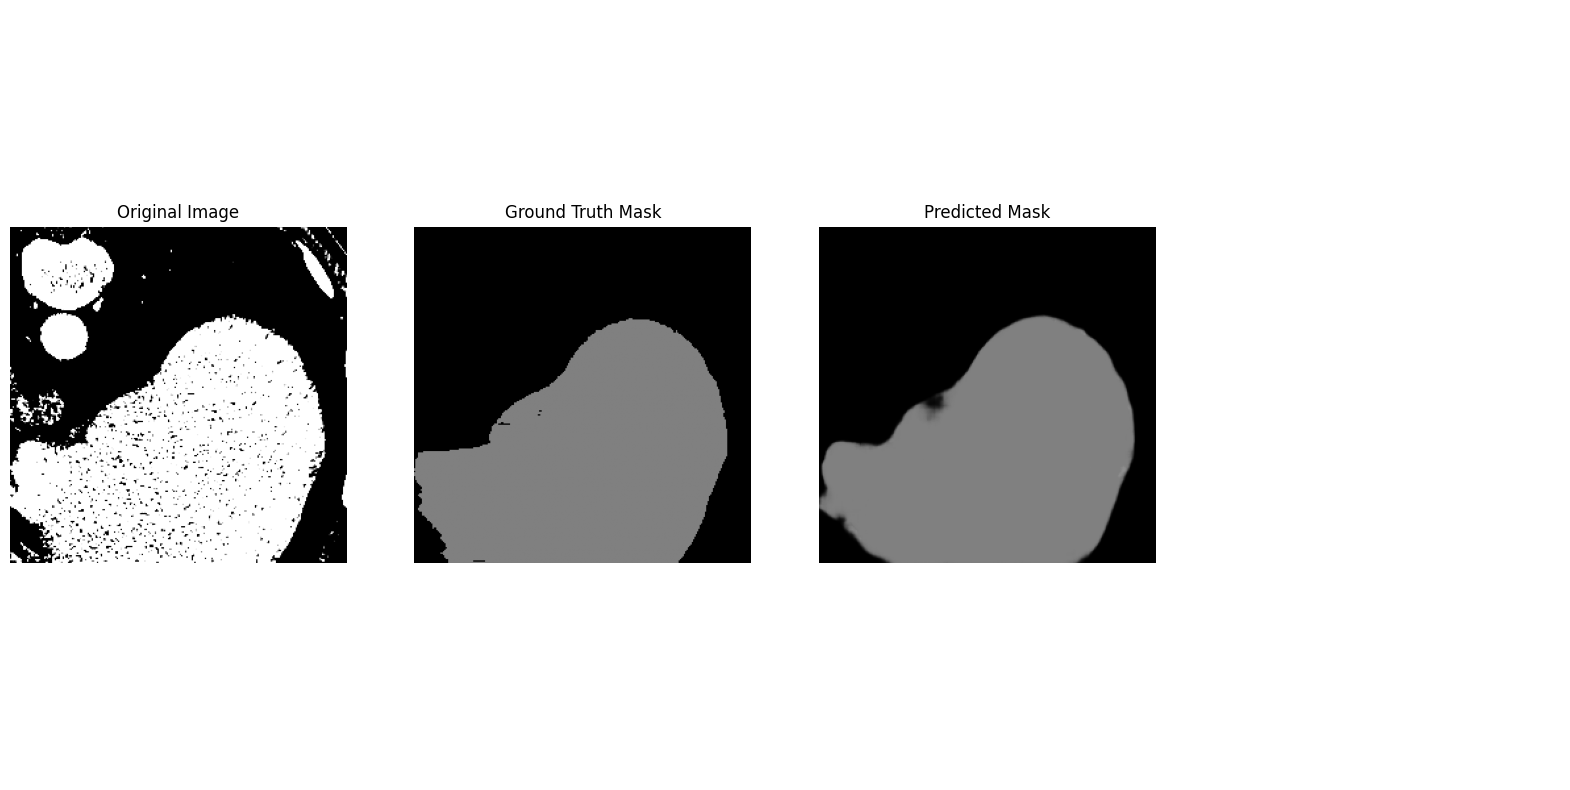

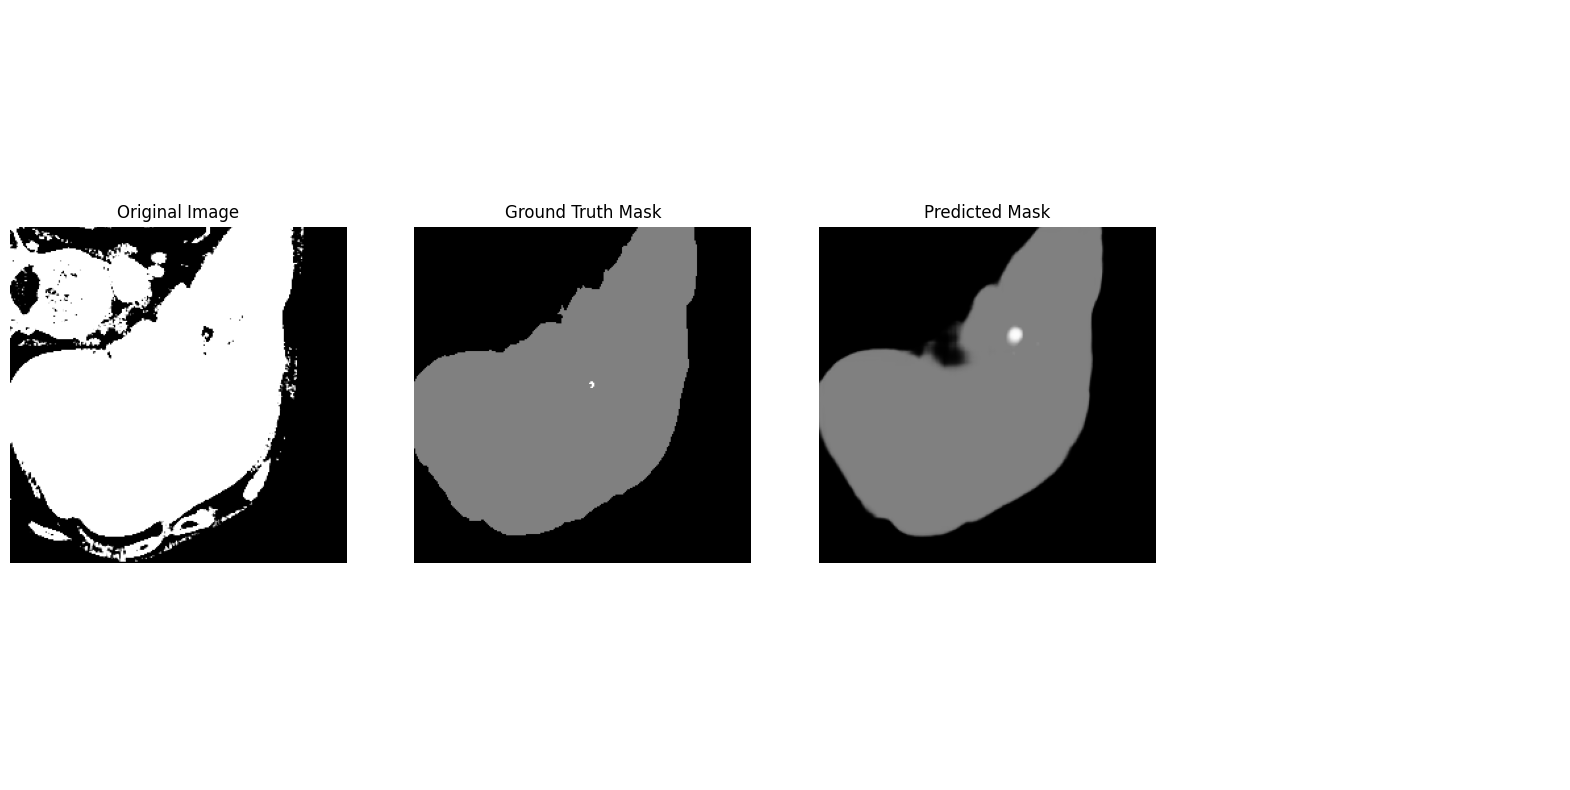

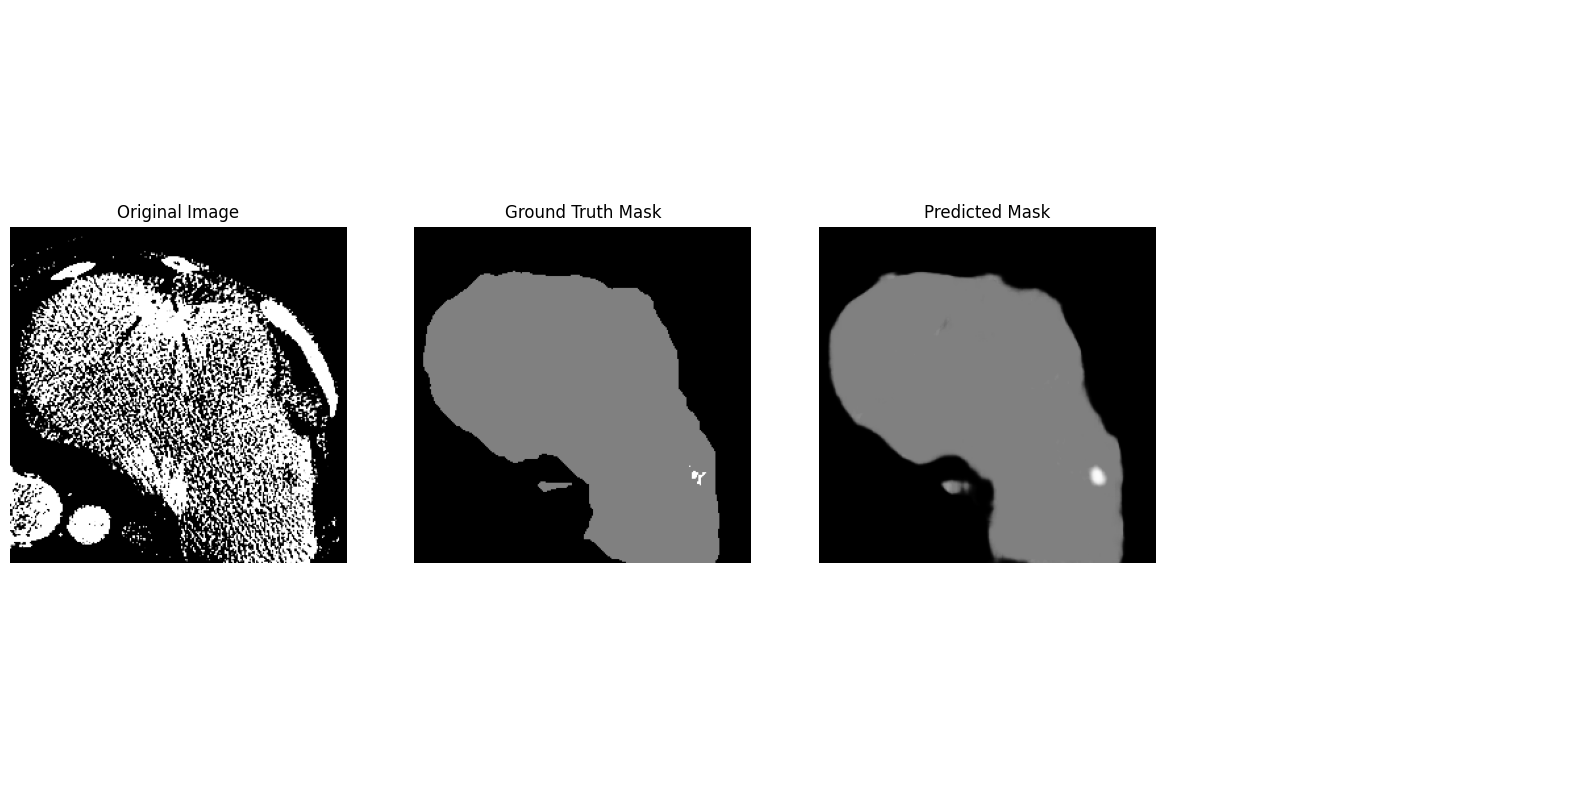

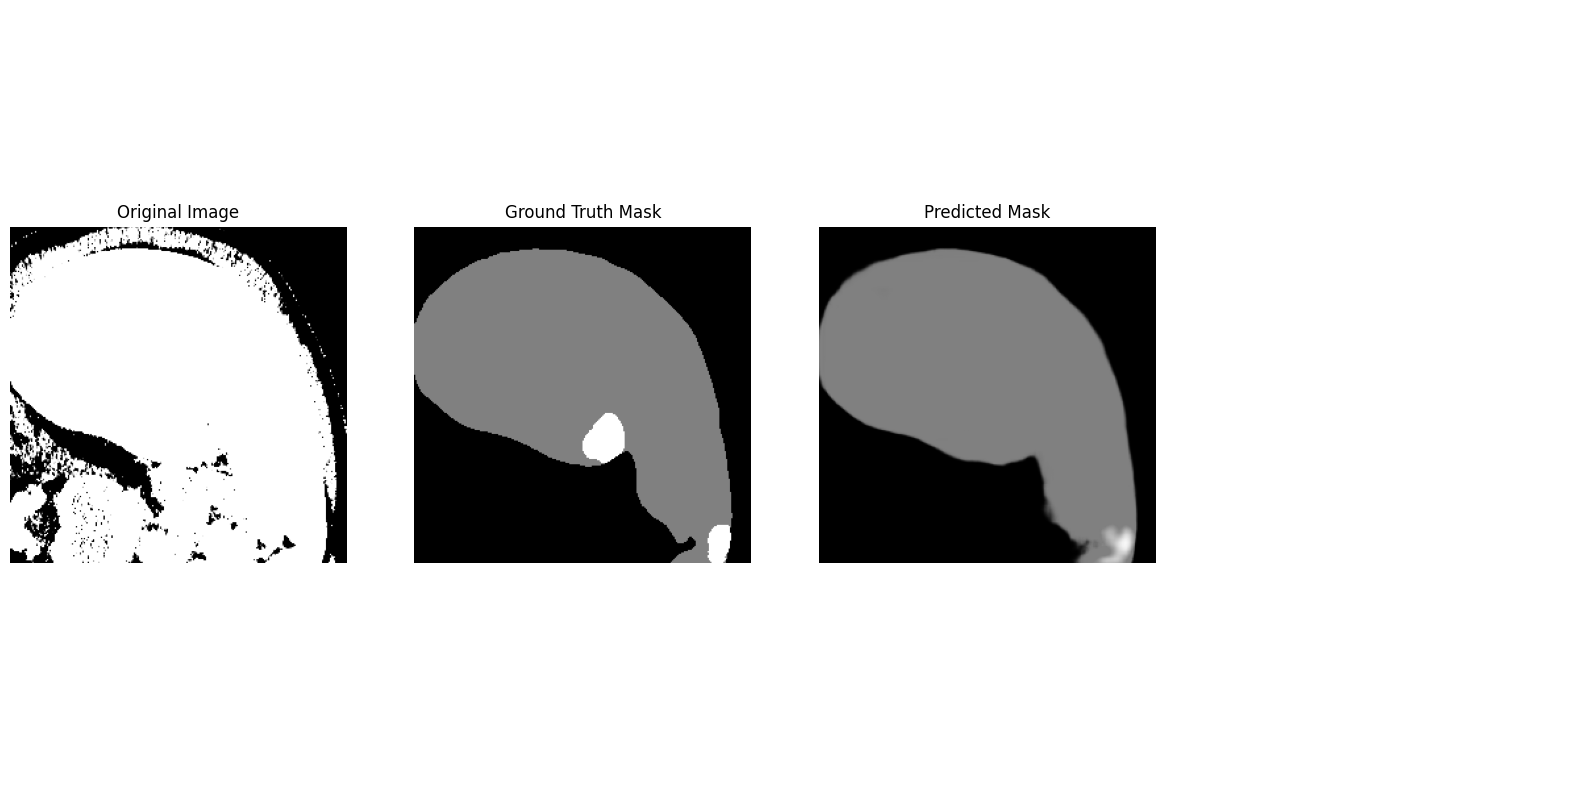

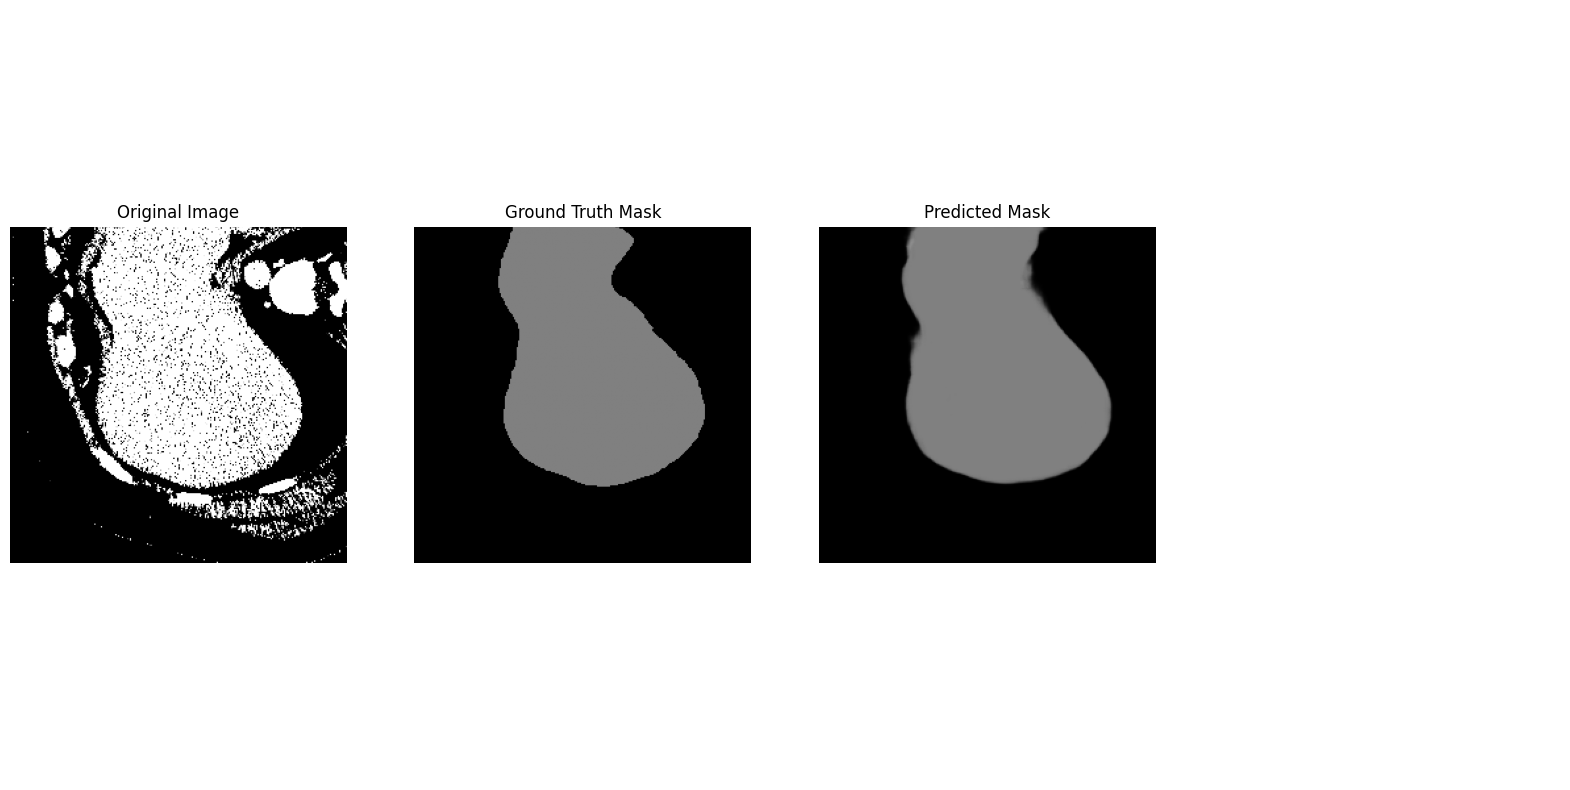

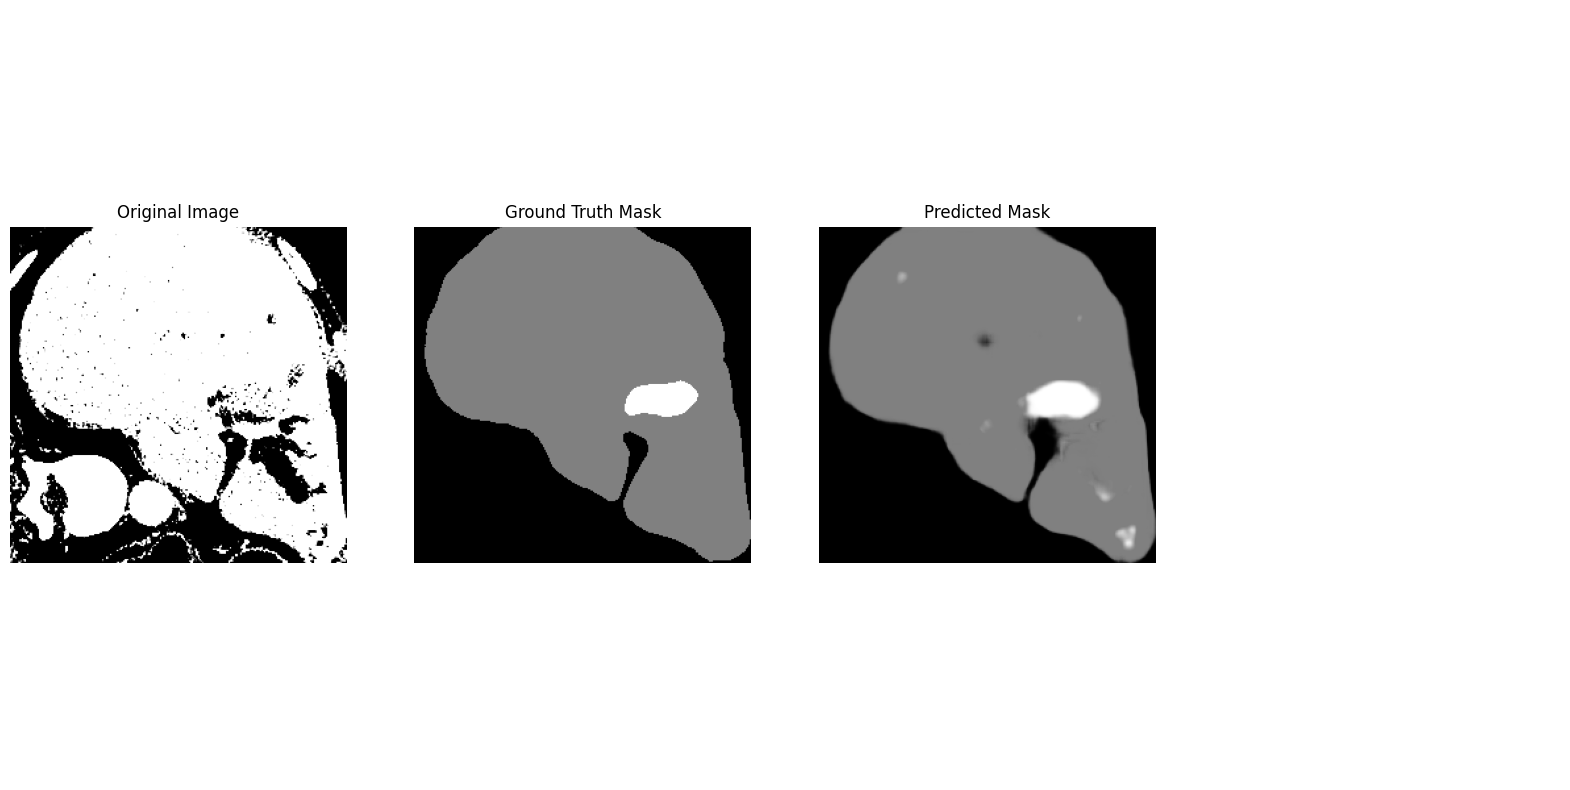

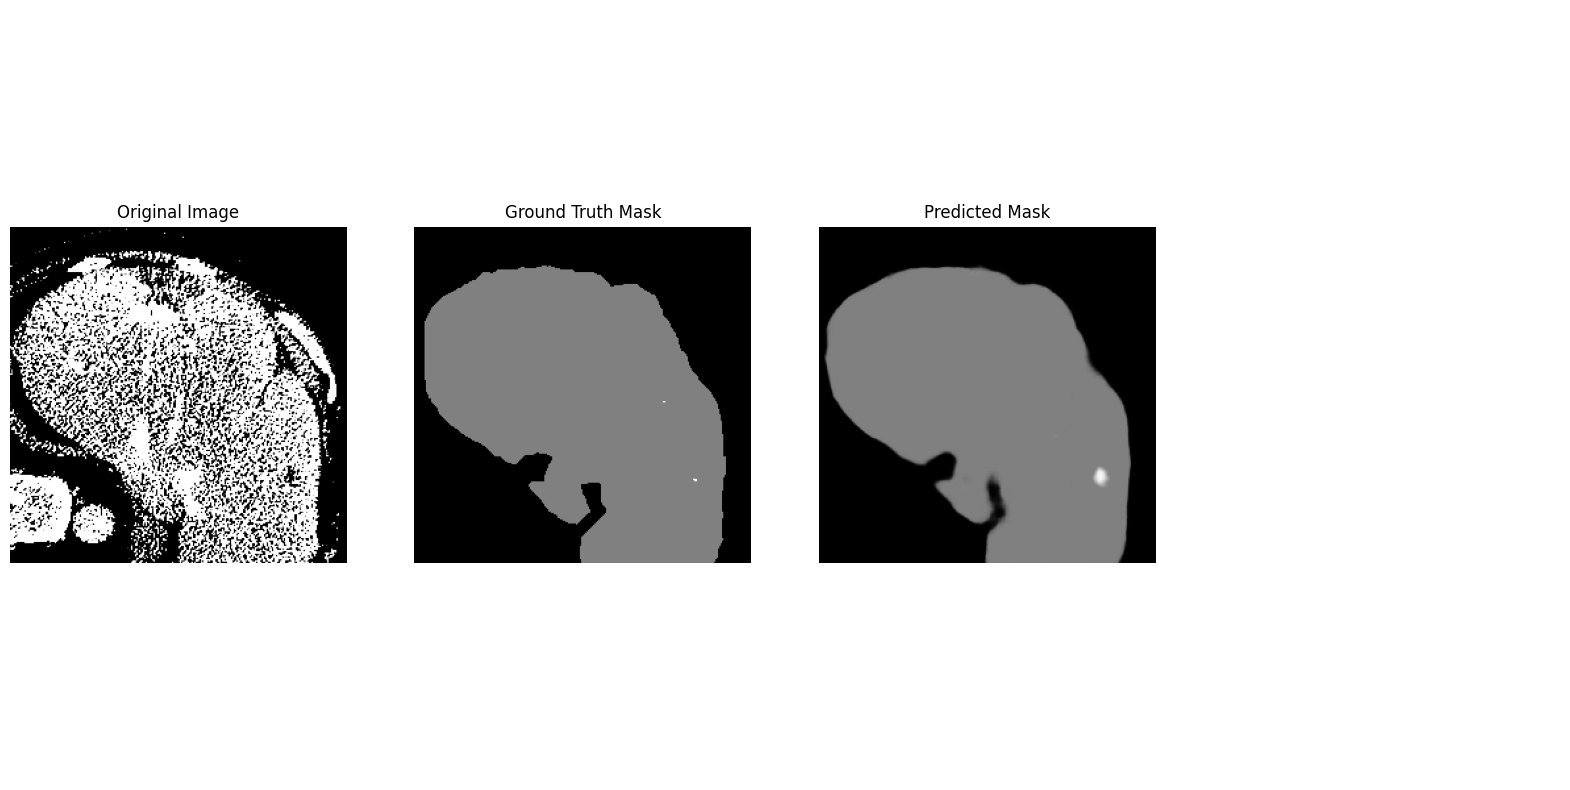

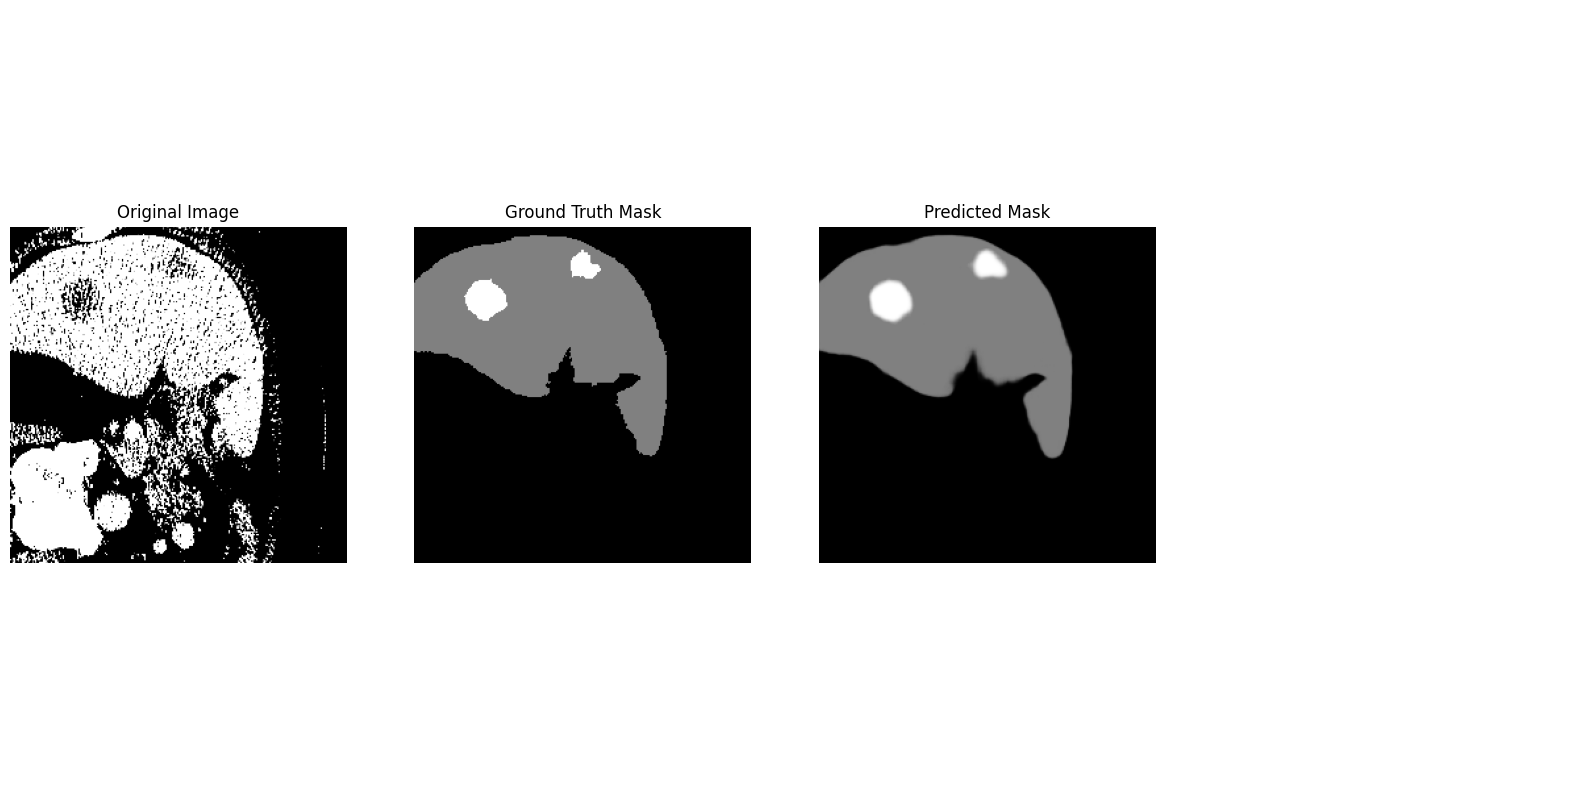

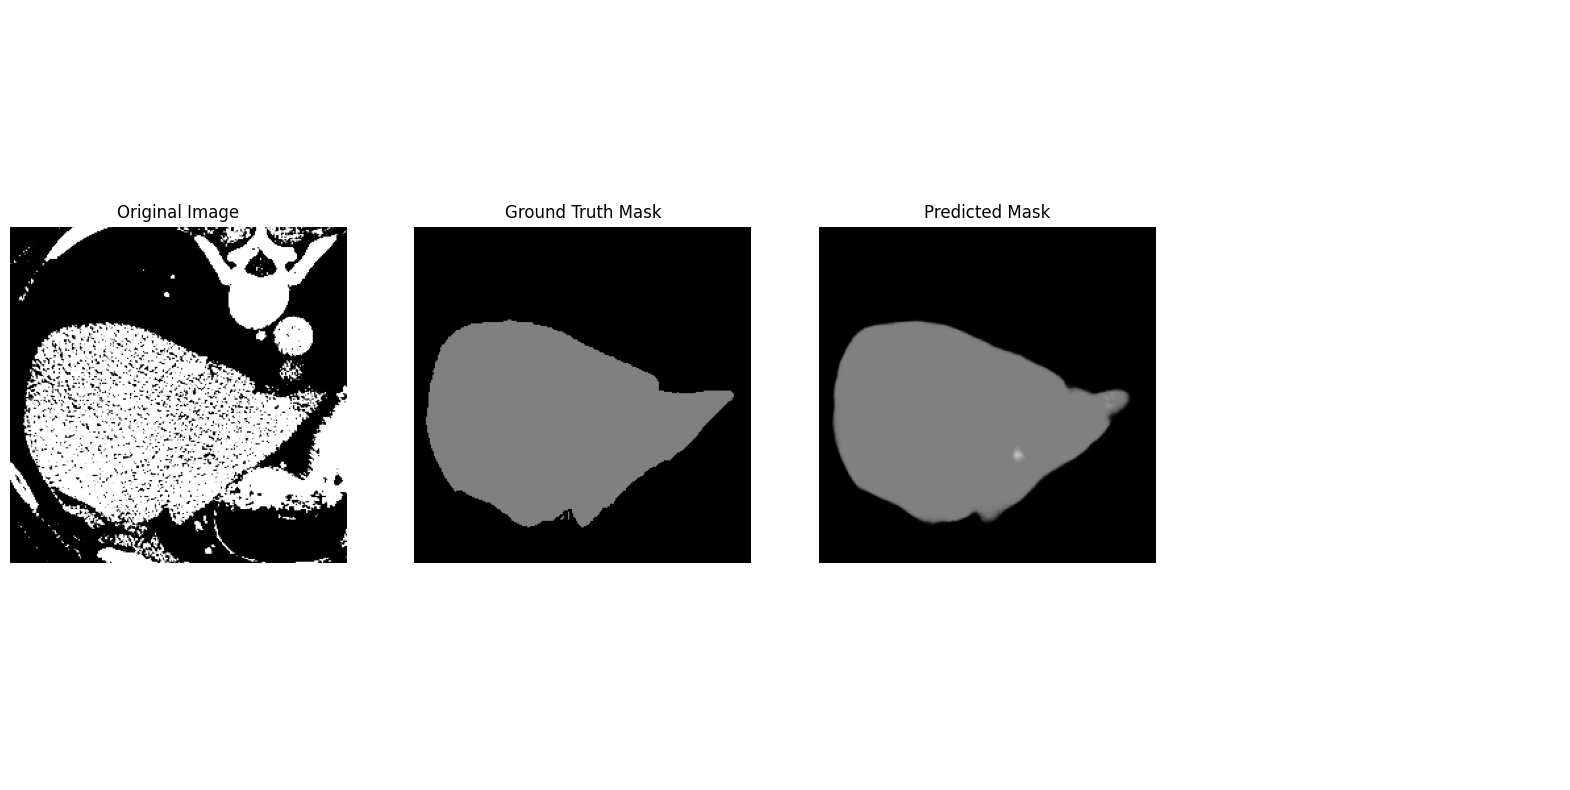

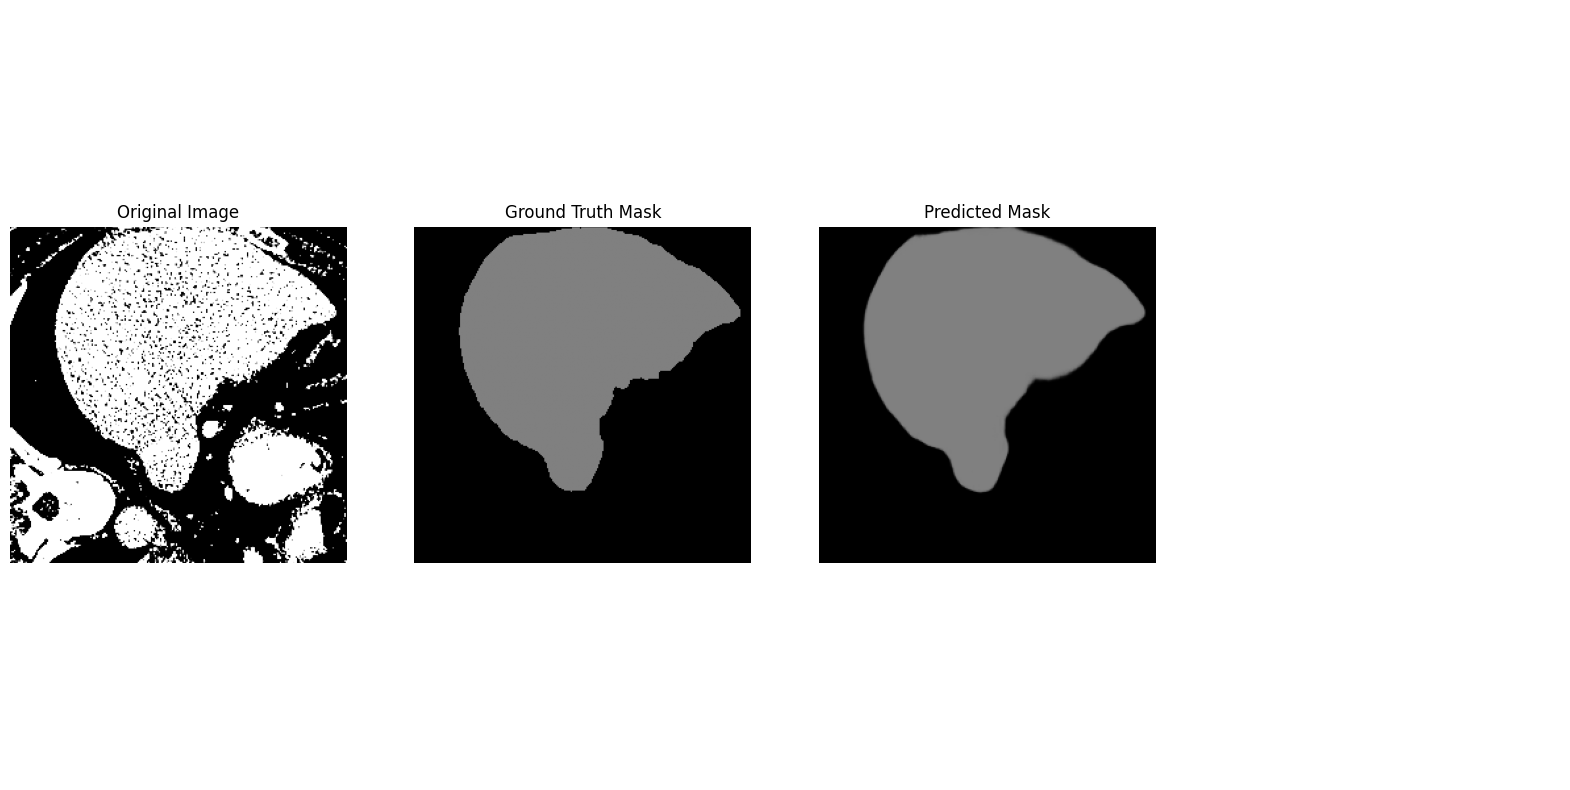

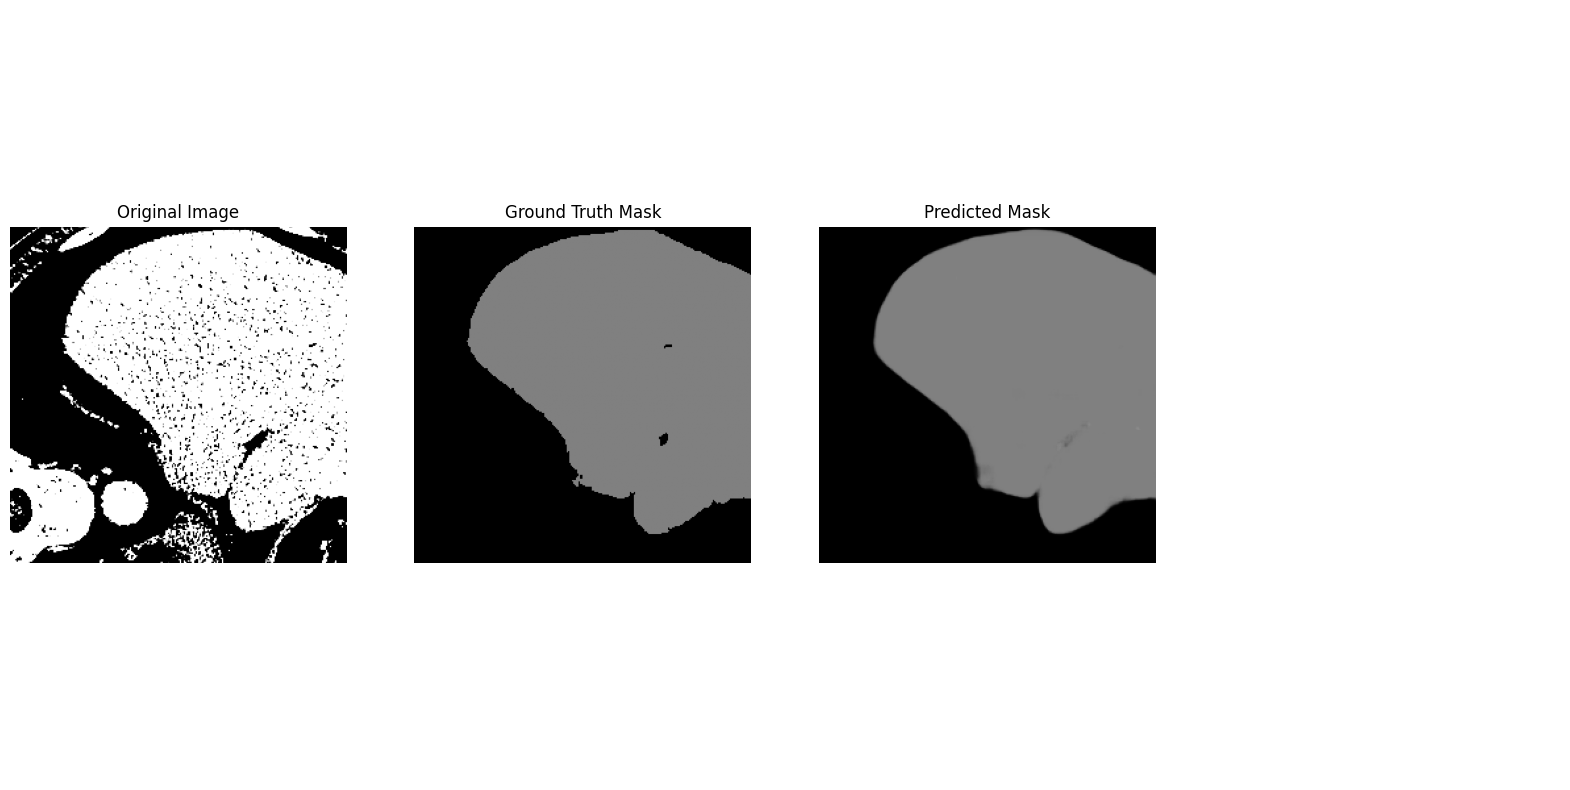

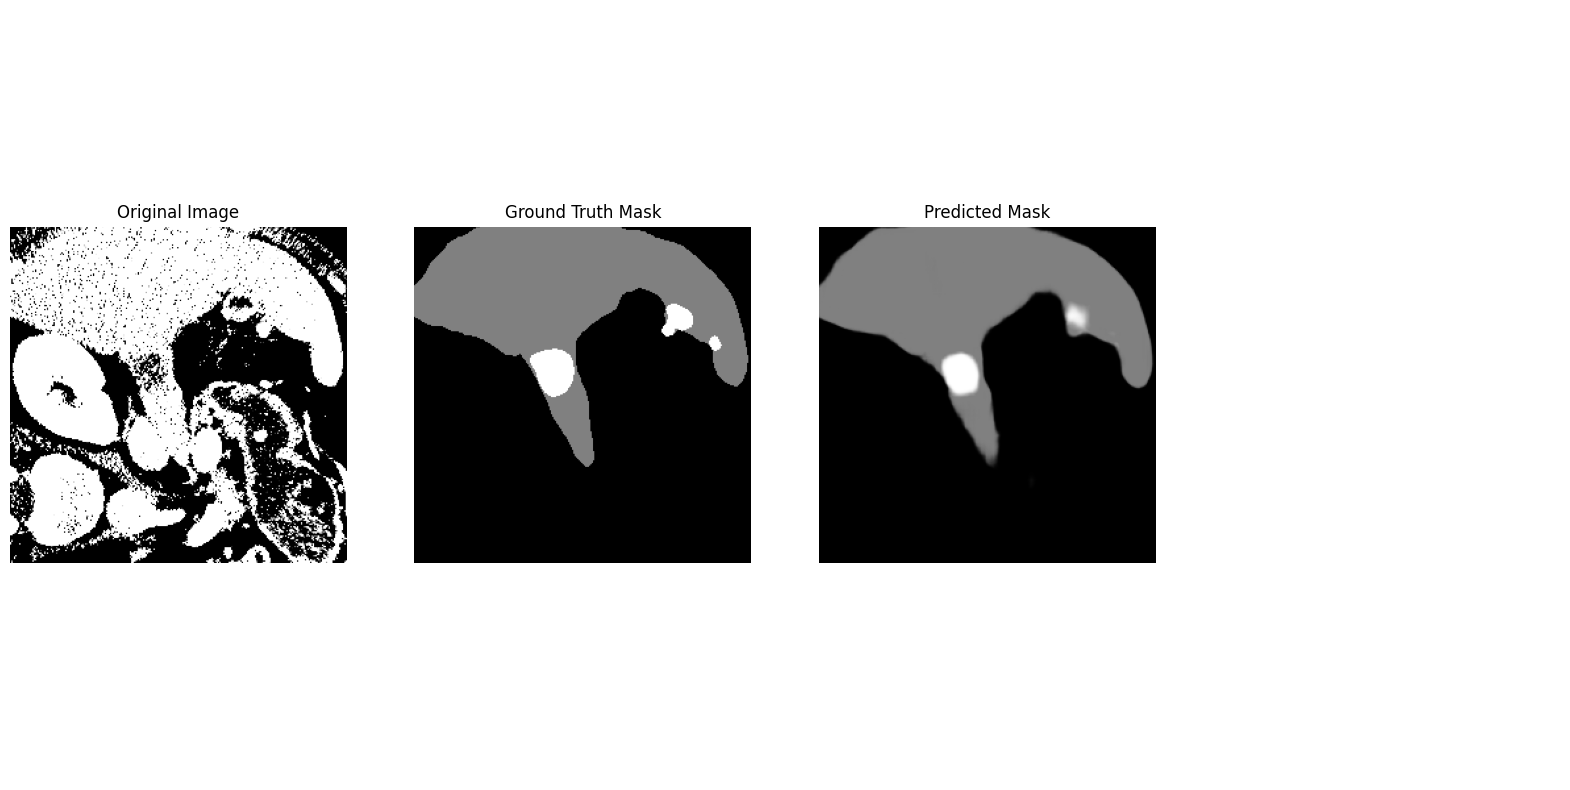

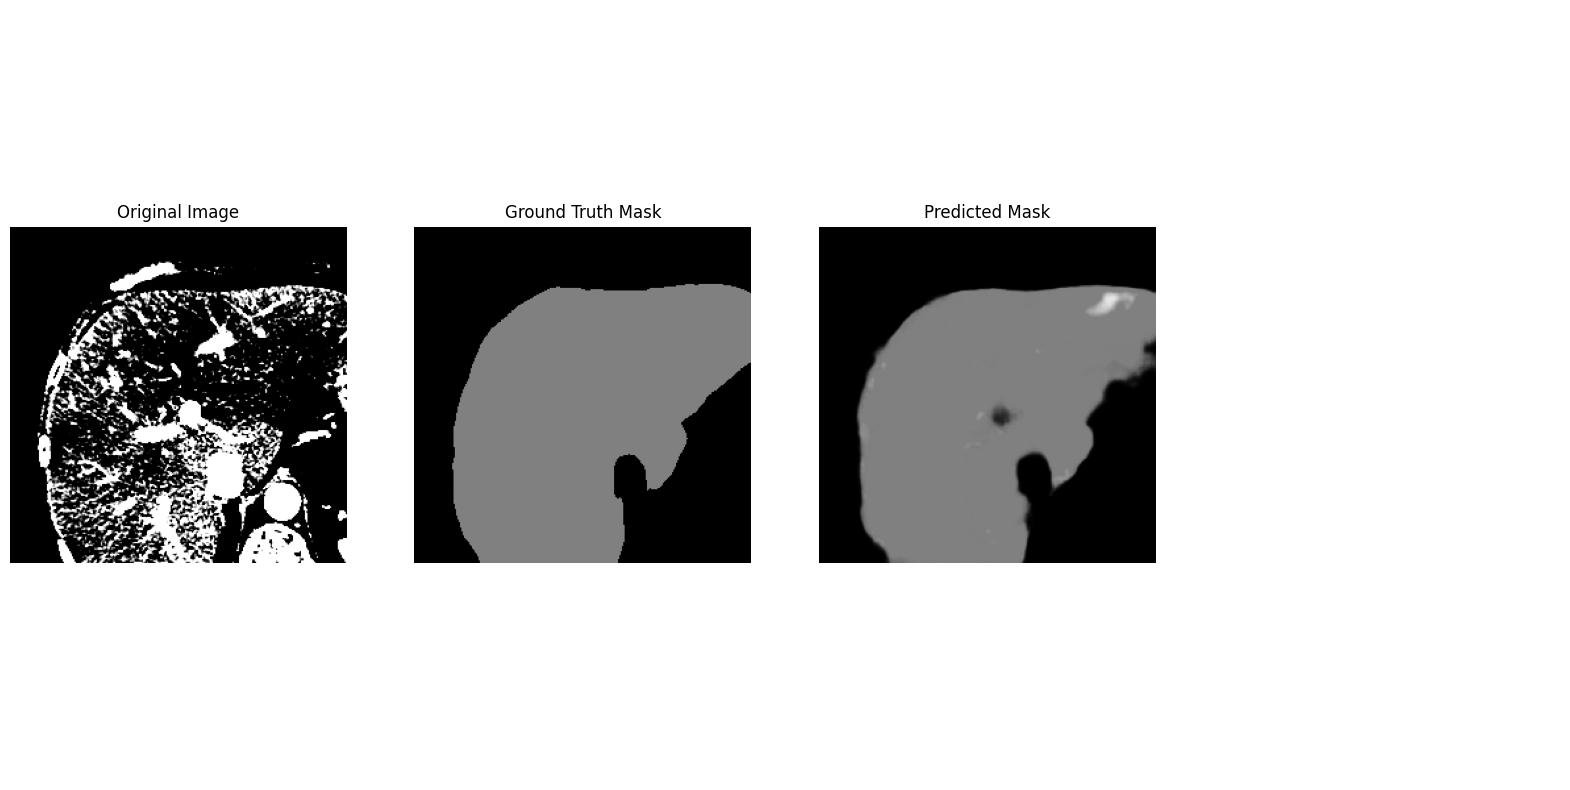

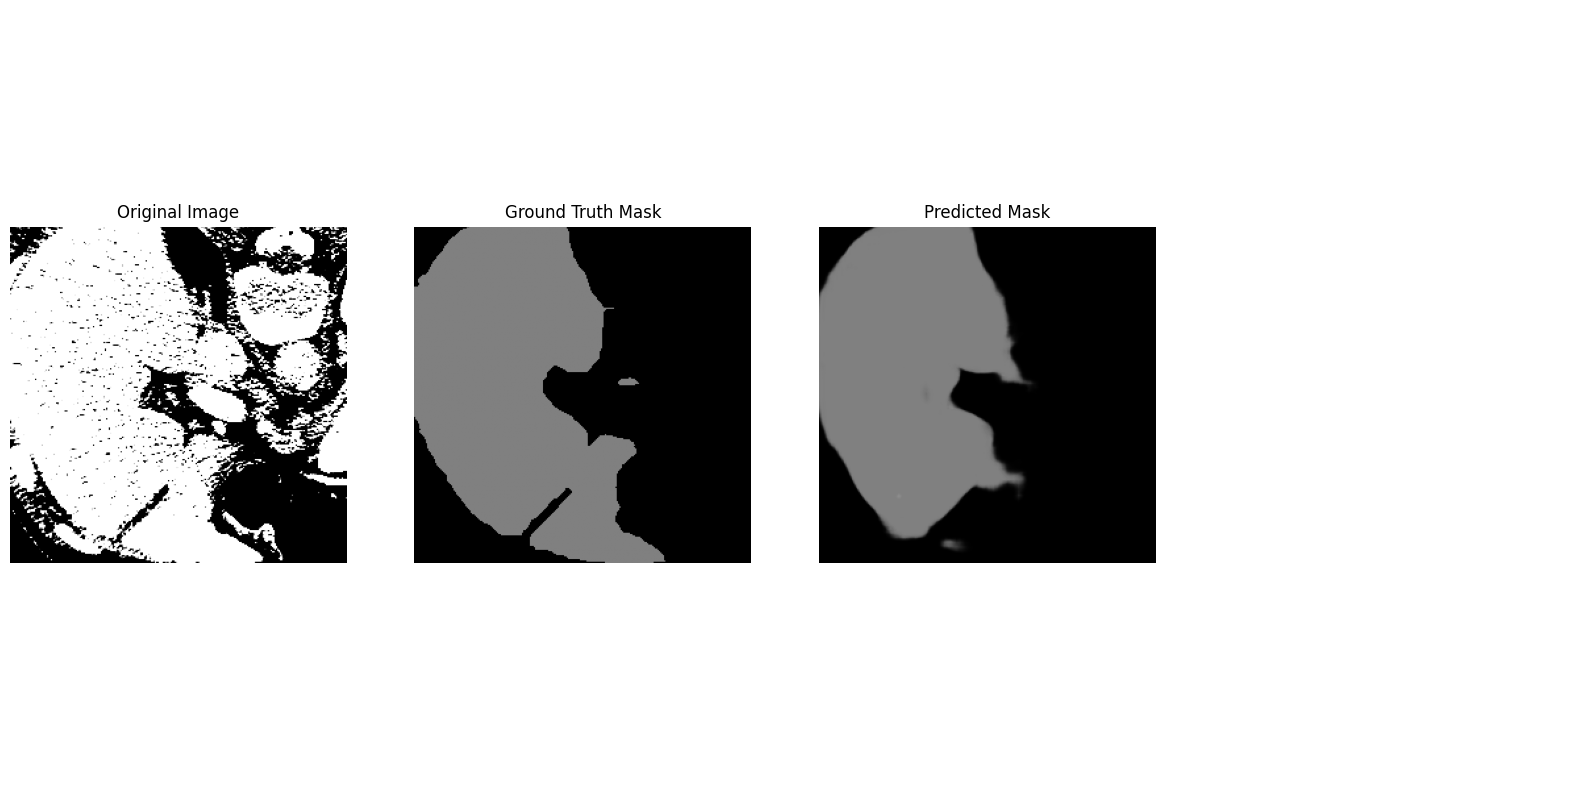

In [14]:
def main():
    # 1. Predict on test data
    y_pred = model.predict(X_test)  # Predict using the model

    # Plot specific results
    print("Plotting selected results from the original dataset...")

    # Plot Example Results
    for i in range(70, 80):
        plot_results(X_test[i], y_test[i], y_pred[i])

    for i in range(200, 210):
        plot_results(X_test[i], y_test[i], y_pred[i])


if __name__ == "__main__":
    main()
